# 🏦 Credit Risk Modeling — Loan Default Prediction
> **Dataset**: [Kaggle — Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data)  
> **Goal**: Predict whether a client will default on a loan (`loan_status = 1`)  
> **Models**: Logistic Regression (L1 / L2), with full mathematical foundations  

---
### 📐 Mathematics Covered
| Concept | Where |
|---|---|
| Logistic Regression / Sigmoid | Section 2 |
| Maximum Likelihood Estimation | Section 2 |
| L1 (Lasso) & L2 (Ridge) Regularization | Section 4 |
| ROC Curve & AUC | Section 5 |
| Eigenvalue Stability of Covariance Matrix | Section 6 |

## 📦 Section 0 — Imports & Setup

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    roc_auc_score, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline

# Aesthetics
plt.style.use('dark_background')
ACCENT  = '#00e5a0'
ACCENT2 = '#ff6b35'
ACCENT3 = '#4d9fff'
DANGER  = '#ff4757'

print('✅ All libraries imported successfully.')

✅ All libraries imported successfully.


---
## 📂 Section 1 — Load & Explore the Dataset

> **Download**: `credit_risk_dataset.csv` from the Kaggle link above and place it in the same folder as this notebook.

In [35]:
df = pd.read_csv('credit_risk_dataset.csv')
print(f'Shape: {df.shape}')
df.head()

Shape: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [36]:
print('=== Data Types & Missing Values ===')
info = pd.DataFrame({
    'dtype': df.dtypes,
    'non_null': df.notnull().sum(),
    'missing': df.isnull().sum(),
    'missing_%': (df.isnull().mean() * 100).round(2)
})
print(info)
print()
print('=== Target Distribution ===')
print(df['loan_status'].value_counts())
print(f'Default rate: {df["loan_status"].mean():.2%}')

=== Data Types & Missing Values ===
                              dtype  non_null  missing  missing_%
person_age                    int64     32581        0       0.00
person_income                 int64     32581        0       0.00
person_home_ownership        object     32581        0       0.00
person_emp_length           float64     31686      895       2.75
loan_intent                  object     32581        0       0.00
loan_grade                   object     32581        0       0.00
loan_amnt                     int64     32581        0       0.00
loan_int_rate               float64     29465     3116       9.56
loan_status                   int64     32581        0       0.00
loan_percent_income         float64     32581        0       0.00
cb_person_default_on_file    object     32581        0       0.00
cb_person_cred_hist_length    int64     32581        0       0.00

=== Target Distribution ===
loan_status
0    25473
1     7108
Name: count, dtype: int64
Default rate: 21.

KeyboardInterrupt: 

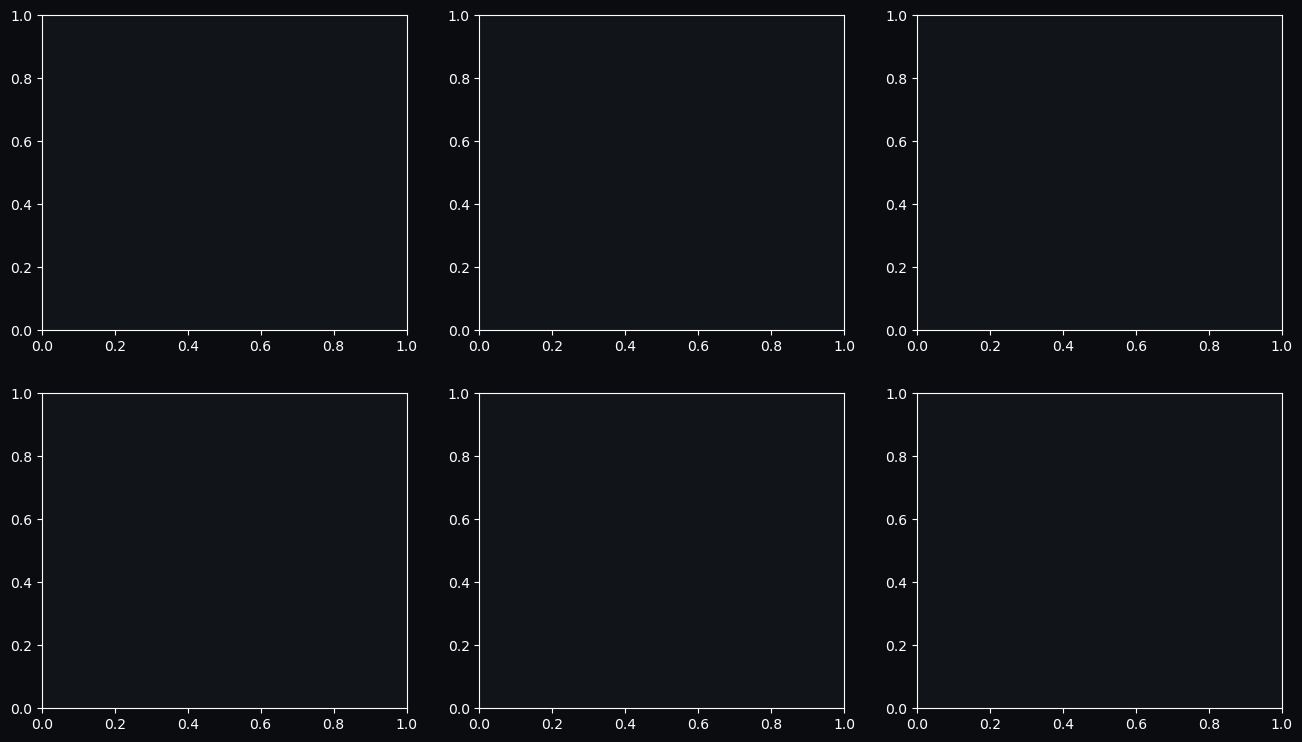

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.patch.set_facecolor('#0a0c10')
for ax in axes.flat:
    ax.set_facecolor('#111418')

num_cols = ['person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income']
colors = [ACCENT, ACCENT2, ACCENT3, DANGER, '#c084fc', '#facc15']

for ax, col, color in zip(axes.flat, num_cols, colors):
    for status, alpha in [(0, 0.5), (1, 0.85)]:
        data = df[df['loan_status'] == status][col].dropna()
        ax.hist(data, bins=40, alpha=alpha, color=color if status == 1 else '#555',
                label='Default' if status == 1 else 'No Default')
    ax.set_title(col, color='white', fontsize=11, pad=8)
    ax.tick_params(colors='#6b7280', labelsize=8)
    ax.spines[:].set_color('#252b35')
    ax.legend(fontsize=8)

fig.suptitle('Feature Distributions by Loan Status', color='white', fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

---
## 🧮 Section 2 — Mathematical Foundation

### 2.1 Logistic Regression & Sigmoid Function

We model the **probability of default** as:

$$P(Y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x} + b)}}$$

where $\mathbf{x}$ is the feature vector, $\mathbf{w}$ the weight vector, and $b$ the bias.

### 2.2 Maximum Likelihood Estimation (MLE)

Given $n$ independent samples, the **log-likelihood** is:

$$\ell(\mathbf{w}) = \sum_{i=1}^{n} \left[ y_i \log \hat{p}_i + (1 - y_i) \log(1 - \hat{p}_i) \right]$$

This is the **binary cross-entropy** loss, negated. MLE finds $\mathbf{w}^*$ that maximizes $\ell(\mathbf{w})$.

There is no closed-form solution → we use **gradient ascent** (or gradient descent on the loss):  
$$\nabla_{\mathbf{w}} \ell = \mathbf{X}^T (\mathbf{y} - \hat{\mathbf{p}})$$

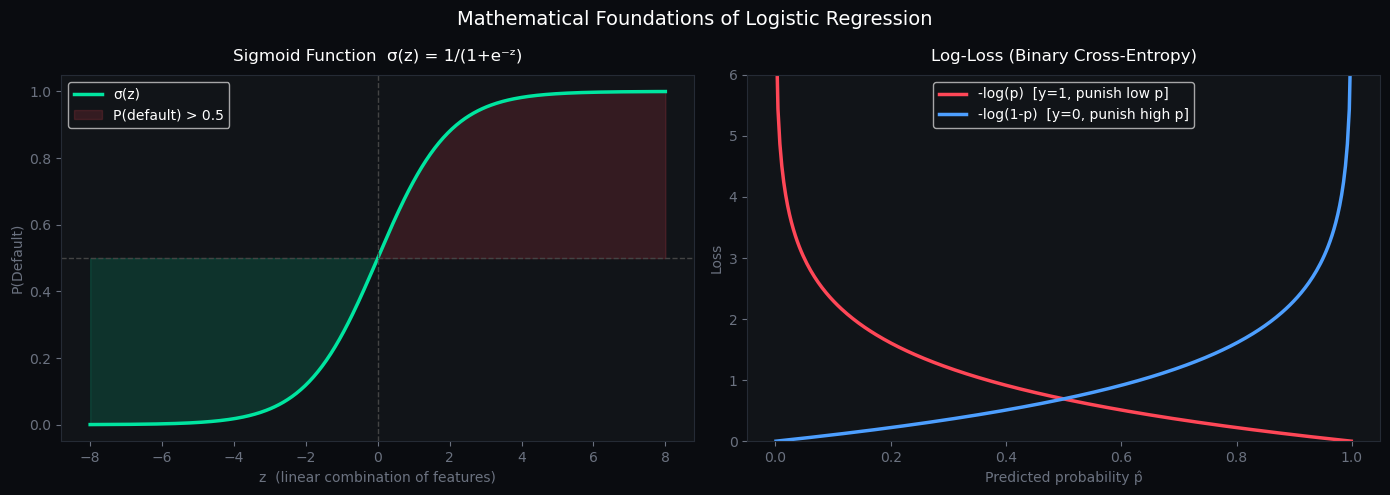

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0a0c10')
for ax in axes:
    ax.set_facecolor('#111418')
    ax.spines[:].set_color('#252b35')
    ax.tick_params(colors='#6b7280')

# Sigmoid
z = np.linspace(-8, 8, 400)
sig = 1 / (1 + np.exp(-z))
axes[0].plot(z, sig, color=ACCENT, lw=2.5, label='σ(z)')
axes[0].axhline(0.5, color='#444', ls='--', lw=1)
axes[0].axvline(0,   color='#444', ls='--', lw=1)
axes[0].fill_between(z, sig, 0.5, where=sig>0.5, alpha=0.15, color=DANGER, label='P(default) > 0.5')
axes[0].fill_between(z, sig, 0.5, where=sig<0.5, alpha=0.15, color=ACCENT)
axes[0].set_title('Sigmoid Function  σ(z) = 1/(1+e⁻ᶻ)', color='white', pad=10)
axes[0].set_xlabel('z  (linear combination of features)', color='#6b7280')
axes[0].set_ylabel('P(Default)', color='#6b7280')
axes[0].legend(facecolor='#111418', labelcolor='white')

# Log-loss surface
p = np.linspace(0.001, 0.999, 300)
axes[1].plot(p, -np.log(p),   color=DANGER,  lw=2.5, label='-log(p)  [y=1, punish low p]')
axes[1].plot(p, -np.log(1-p), color=ACCENT3, lw=2.5, label='-log(1-p)  [y=0, punish high p]')
axes[1].set_ylim(0, 6)
axes[1].set_title('Log-Loss (Binary Cross-Entropy)', color='white', pad=10)
axes[1].set_xlabel('Predicted probability p̂', color='#6b7280')
axes[1].set_ylabel('Loss', color='#6b7280')
axes[1].legend(facecolor='#111418', labelcolor='white')

fig.suptitle('Mathematical Foundations of Logistic Regression', color='white', fontsize=14)
plt.tight_layout()
plt.show()

---
## 🧹 Section 3 — Data Preprocessing

In [ ]:
# ── 1. Handle missing values ──────────────────────────────────────────────────
print('Missing before:', df.isnull().sum()[df.isnull().sum() > 0].to_dict())

df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

print('Missing after: ', df.isnull().sum().sum())

# ── 2. Remove outliers (extreme ages / emp lengths that are physiologically impossible)
df = df[(df['person_age'] < 100) & (df['person_emp_length'] <= df['person_age'])]
print(f'Shape after outlier removal: {df.shape}')

# ── 3. Encode categorical variables ──────────────────────────────────────────
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print(f'Shape after encoding: {df_enc.shape}')

# ── 4. Split features / target ────────────────────────────────────────────────
X = df_enc.drop('loan_status', axis=1)
y = df_enc['loan_status']

# ── 5. Train / test split (stratified) ────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Train: {X_train.shape} | Test: {X_test.shape}')
print(f'Train default rate: {y_train.mean():.2%} | Test: {y_test.mean():.2%}')

# ── 6. Feature scaling (StandardScaler) ───────────────────────────────────────
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)
print('\n✅ Preprocessing complete.')

Missing before: {'person_emp_length': 895, 'loan_int_rate': 3116}
Missing after:  0
Shape after outlier removal: (32574, 12)
Shape after encoding: (32574, 23)
Train: (26059, 22) | Test: (6515, 22)
Train default rate: 21.82% | Test: 21.81%

✅ Preprocessing complete.


---
## ⚖️ Section 4 — Regularization: L1 vs L2

To prevent overfitting we add a **penalty** to the loss function:

| Method | Penalized Loss | Effect |
|---|---|---|
| **L2 (Ridge)** | $\ell(\mathbf{w}) - \lambda \|\mathbf{w}\|_2^2$ | Shrinks all weights; no sparsity |
| **L1 (Lasso)** | $\ell(\mathbf{w}) - \lambda \|\mathbf{w}\|_1$ | Drives some weights to **exactly 0** → automatic feature selection |

$C = 1/\lambda$ in scikit-learn (smaller $C$ = stronger regularization).

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results = []

for penalty in ['l1', 'l2']:
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    for C in C_values:
        model = LogisticRegression(penalty=penalty, C=C, solver=solver,
                                   max_iter=1000, random_state=42)
        cv_scores = cross_val_score(model, X_train_sc, y_train,
                                    cv=StratifiedKFold(5), scoring='roc_auc')
        results.append({'penalty': penalty, 'C': C,
                         'auc_mean': cv_scores.mean(),
                         'auc_std':  cv_scores.std()})

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

penalty       C  auc_mean  auc_std
     l1   0.001  0.839465 0.008611
     l1   0.010  0.869719 0.006074
     l1   0.100  0.870951 0.005698
     l1   1.000  0.870900 0.005657
     l1  10.000  0.870893 0.005648
     l1 100.000  0.870893 0.005647
     l2   0.001  0.866012 0.006726
     l2   0.010  0.870573 0.005972
     l2   0.100  0.870923 0.005660
     l2   1.000  0.870897 0.005640
     l2  10.000  0.870902 0.005643
     l2 100.000  0.870903 0.005642


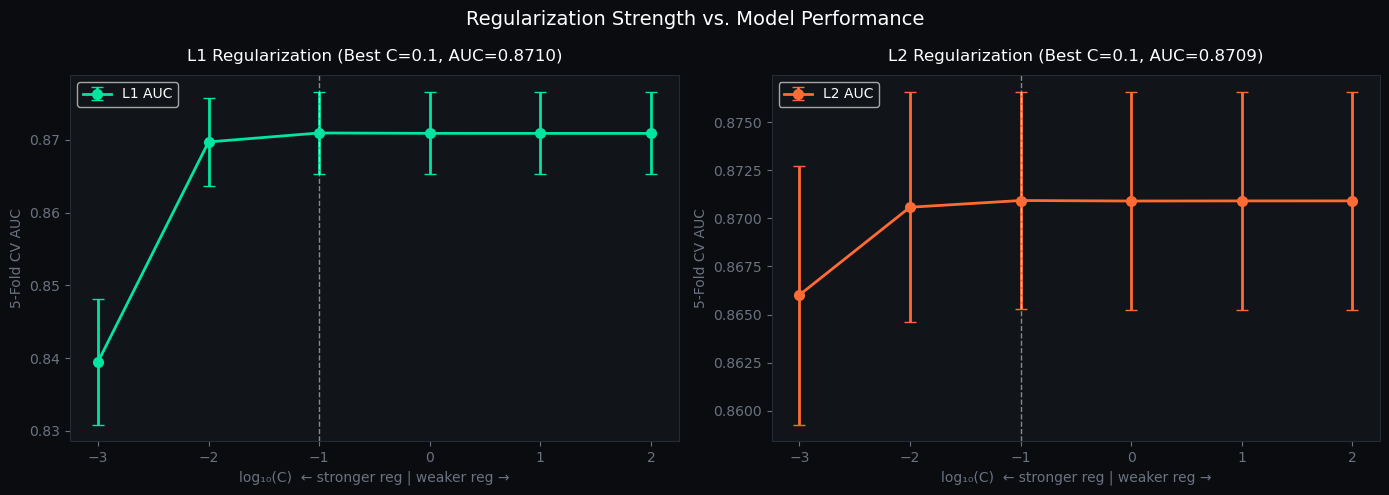

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0a0c10')

for ax, (penalty, color) in zip(axes, [('l1', ACCENT), ('l2', ACCENT2)]):
    ax.set_facecolor('#111418')
    ax.spines[:].set_color('#252b35')
    ax.tick_params(colors='#6b7280')
    sub = res_df[res_df['penalty'] == penalty]
    ax.errorbar(np.log10(sub['C']), sub['auc_mean'],
                yerr=sub['auc_std'], color=color, marker='o',
                markersize=7, lw=2, capsize=4, label=f'{penalty.upper()} AUC')
    best_idx = sub['auc_mean'].idxmax()
    best_C = sub.loc[best_idx, 'C']
    best_auc = sub.loc[best_idx, 'auc_mean']
    ax.axvline(np.log10(best_C), color='white', ls='--', lw=1, alpha=0.5)
    ax.set_title(f'{penalty.upper()} Regularization (Best C={best_C}, AUC={best_auc:.4f})',
                 color='white', pad=10)
    ax.set_xlabel('log₁₀(C)  ← stronger reg | weaker reg →', color='#6b7280')
    ax.set_ylabel('5-Fold CV AUC', color='#6b7280')
    ax.legend(facecolor='#111418', labelcolor='white')

fig.suptitle('Regularization Strength vs. Model Performance', color='white', fontsize=14)
plt.tight_layout()
plt.show()

---
## 🏋️ Section 5 — Train Final Models & ROC Curve Analysis

### ROC Curve
The **Receiver Operating Characteristic** curve plots **TPR vs FPR** at every decision threshold $\tau$:

$$\text{TPR}(\tau) = \frac{TP}{TP + FN}, \quad \text{FPR}(\tau) = \frac{FP}{FP + TN}$$

**AUC** = Area Under the ROC Curve.  
- AUC = 1.0 → perfect model  
- AUC = 0.5 → random guess  

In [ ]:
# ── Best models from CV results ────────────────────────────────────────────────
best_l1_C = res_df[res_df['penalty']=='l1'].sort_values('auc_mean').iloc[-1]['C']
best_l2_C = res_df[res_df['penalty']=='l2'].sort_values('auc_mean').iloc[-1]['C']

model_l1 = LogisticRegression(penalty='l1', C=best_l1_C, solver='liblinear',
                               max_iter=2000, random_state=42)
model_l2 = LogisticRegression(penalty='l2', C=best_l2_C, solver='lbfgs',
                               max_iter=2000, random_state=42)

model_l1.fit(X_train_sc, y_train)
model_l2.fit(X_train_sc, y_train)

for name, model in [('L1 (Lasso)', model_l1), ('L2 (Ridge)', model_l2)]:
    proba = model.predict_proba(X_test_sc)[:, 1]
    auc   = roc_auc_score(y_test, proba)
    print(f'{name:15s} | Test AUC = {auc:.4f}')

print('\n✅ Models trained.')

L1 (Lasso)      | Test AUC = 0.8625
L2 (Ridge)      | Test AUC = 0.8624

✅ Models trained.


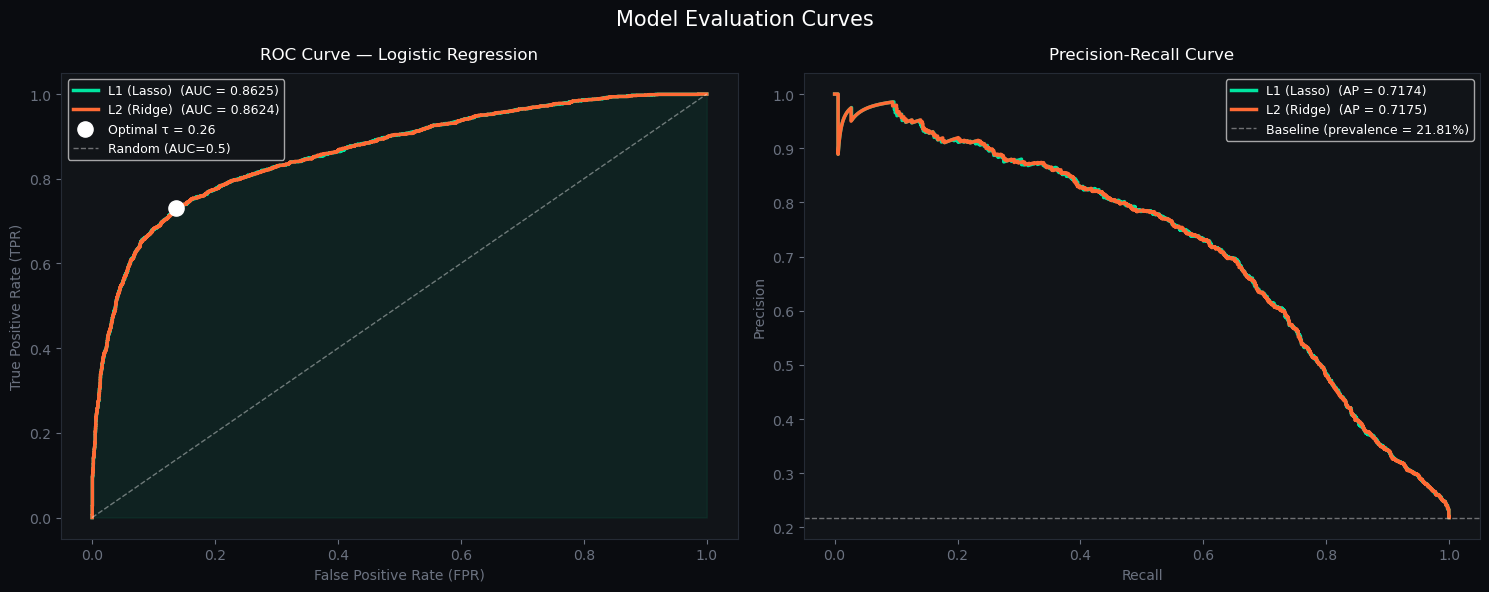


🎯 Optimal decision threshold (Youden J): 0.2640


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#0a0c10')

# ── Left: ROC Curve ────────────────────────────────────────────────────────────
ax = axes[0]
ax.set_facecolor('#111418')
ax.spines[:].set_color('#252b35')
ax.tick_params(colors='#6b7280')

models_info = [
    ('L1 (Lasso)', model_l1, ACCENT),
    ('L2 (Ridge)', model_l2, ACCENT2),
]
best_model = None
best_auc = 0

for name, model, color in models_info:
    proba = model.predict_proba(X_test_sc)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, color=color, lw=2.5, label=f'{name}  (AUC = {auc:.4f})')
    if auc > best_auc:
        best_auc = auc
        best_model = model
        best_proba = proba
        best_fpr, best_tpr, best_thresh = fpr, tpr, thresholds

# Optimal threshold (Youden's J)
J = best_tpr - best_fpr
opt_idx = np.argmax(J)
opt_thresh = best_thresh[opt_idx]
ax.scatter(best_fpr[opt_idx], best_tpr[opt_idx], s=120, color='white',
           zorder=5, label=f'Optimal τ = {opt_thresh:.2f}')

ax.plot([0,1], [0,1], 'w--', lw=1, alpha=0.4, label='Random (AUC=0.5)')
ax.fill_between(best_fpr, best_tpr, alpha=0.07, color=ACCENT)
ax.set_xlabel('False Positive Rate (FPR)', color='#6b7280')
ax.set_ylabel('True Positive Rate (TPR)', color='#6b7280')
ax.set_title('ROC Curve — Logistic Regression', color='white', pad=10)
ax.legend(facecolor='#111418', labelcolor='white', fontsize=9)

# ── Right: Precision-Recall Curve ─────────────────────────────────────────────
ax2 = axes[1]
ax2.set_facecolor('#111418')
ax2.spines[:].set_color('#252b35')
ax2.tick_params(colors='#6b7280')

for name, model, color in models_info:
    proba = model.predict_proba(X_test_sc)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    ax2.plot(rec, prec, color=color, lw=2.5, label=f'{name}  (AP = {ap:.4f})')

baseline = y_test.mean()
ax2.axhline(baseline, color='white', ls='--', lw=1, alpha=0.4,
            label=f'Baseline (prevalence = {baseline:.2%})')
ax2.set_xlabel('Recall', color='#6b7280')
ax2.set_ylabel('Precision', color='#6b7280')
ax2.set_title('Precision-Recall Curve', color='white', pad=10)
ax2.legend(facecolor='#111418', labelcolor='white', fontsize=9)

fig.suptitle('Model Evaluation Curves', color='white', fontsize=15)
plt.tight_layout()
plt.show()
print(f'\n🎯 Optimal decision threshold (Youden J): {opt_thresh:.4f}')

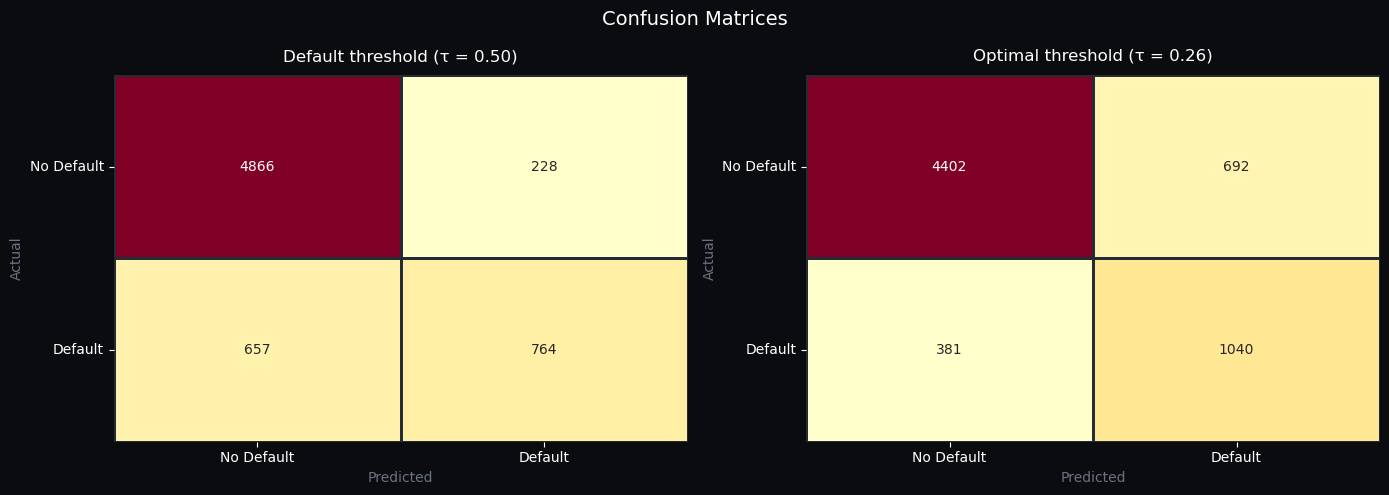


=== Classification Report (Optimal Threshold) ===
              precision    recall  f1-score   support

  No Default       0.92      0.86      0.89      5094
     Default       0.60      0.73      0.66      1421

    accuracy                           0.84      6515
   macro avg       0.76      0.80      0.78      6515
weighted avg       0.85      0.84      0.84      6515



In [ ]:
# ── Confusion matrix at optimal threshold ─────────────────────────────────────
y_pred_opt = (best_proba >= opt_thresh).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0a0c10')

for ax, (thresh, pred, title) in zip(axes, [
    (0.5,       (best_proba >= 0.5).astype(int), 'Default threshold (τ = 0.50)'),
    (opt_thresh, y_pred_opt,                      f'Optimal threshold (τ = {opt_thresh:.2f})'),
]):
    ax.set_facecolor('#111418')
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
                cbar=False, linewidths=1, linecolor='#252b35')
    ax.set_xlabel('Predicted', color='#6b7280')
    ax.set_ylabel('Actual',    color='#6b7280')
    ax.set_title(title, color='white', pad=10)
    ax.tick_params(colors='white')
    ax.set_xticklabels(['No Default', 'Default'])
    ax.set_yticklabels(['No Default', 'Default'], rotation=0)

fig.suptitle('Confusion Matrices', color='white', fontsize=14)
plt.tight_layout()
plt.show()

print('\n=== Classification Report (Optimal Threshold) ===')
print(classification_report(y_test, y_pred_opt, target_names=['No Default', 'Default']))

---
## 🔬 Section 6 — Eigenvalue Stability of the Covariance Matrix

The **covariance matrix** $\Sigma = \frac{1}{n} X^T X$ encodes feature correlations.  
Its **eigenvalues** $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_p$ reveal:

- **Directions of maximum variance** (eigenvectors → principal components)
- **Multicollinearity** / **ill-conditioning** when $\lambda_{min} \approx 0$
- **Condition number** $\kappa = \lambda_{max} / \lambda_{min}$ → if large, logistic regression is numerically unstable and regularization is critical

$$\kappa(\Sigma) = \frac{\lambda_{max}}{\lambda_{min}}$$

L2 regularization effectively replaces $\Sigma$ with $\Sigma + \lambda I$, lifting all eigenvalues away from zero and ensuring stability.

In [ ]:
# ── Compute covariance matrix & eigenvalues ────────────────────────────────────
cov_matrix = np.cov(X_train_sc.T)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
eigenvalues = eigenvalues[::-1]  # Descending order
eigenvectors = eigenvectors[:, ::-1]

condition_number = eigenvalues[0] / eigenvalues[-1]
explained_variance_ratio = eigenvalues / eigenvalues.sum()
cumulative_var = np.cumsum(explained_variance_ratio)

print(f'📐 Covariance Matrix Shape   : {cov_matrix.shape}')
print(f'   λ_max                    : {eigenvalues[0]:.4f}')
print(f'   λ_min                    : {eigenvalues[-1]:.6f}')
print(f'   Condition number κ        : {condition_number:.2f}')
print(f'   Components for 95% var   : {np.searchsorted(cumulative_var, 0.95)+1}')

if condition_number > 1000:
    print('⚠️  High condition number → matrix is ill-conditioned → L2 regularization is crucial!')
else:
    print('✅  Condition number acceptable — matrix is well-conditioned.')

📐 Covariance Matrix Shape   : (22, 22)
   λ_max                    : 2.2755
   λ_min                    : 0.058777
   Condition number κ        : 38.71
   Components for 95% var   : 17
✅  Condition number acceptable — matrix is well-conditioned.


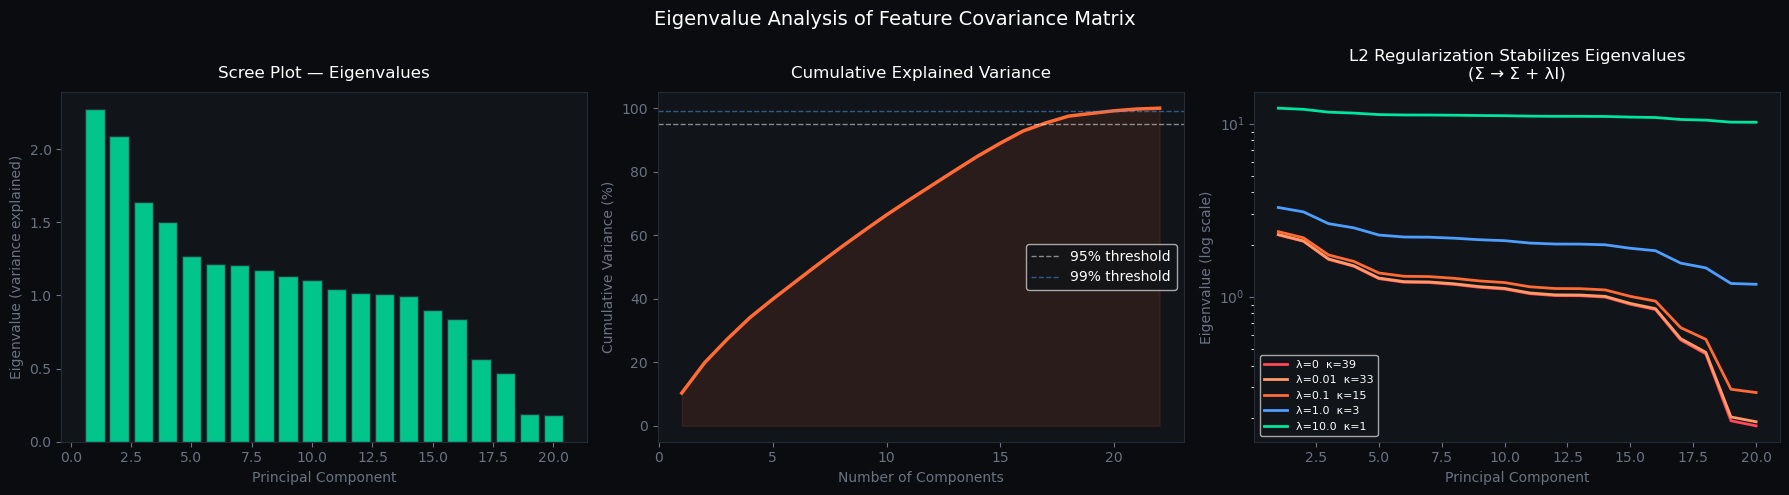

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('#0a0c10')
for ax in axes:
    ax.set_facecolor('#111418')
    ax.spines[:].set_color('#252b35')
    ax.tick_params(colors='#6b7280')

# ── 1. Scree plot ──────────────────────────────────────────────────────────────
n_show = min(20, len(eigenvalues))
axes[0].bar(range(1, n_show+1), eigenvalues[:n_show],
            color=ACCENT, alpha=0.85, edgecolor='#252b35')
axes[0].set_title('Scree Plot — Eigenvalues', color='white', pad=10)
axes[0].set_xlabel('Principal Component', color='#6b7280')
axes[0].set_ylabel('Eigenvalue (variance explained)', color='#6b7280')

# ── 2. Cumulative variance ─────────────────────────────────────────────────────
axes[1].plot(range(1, len(eigenvalues)+1), cumulative_var * 100,
             color=ACCENT2, lw=2.5)
axes[1].axhline(95, color='white', ls='--', lw=1, alpha=0.5, label='95% threshold')
axes[1].axhline(99, color=ACCENT3, ls='--', lw=1, alpha=0.5, label='99% threshold')
axes[1].fill_between(range(1, len(eigenvalues)+1), cumulative_var*100,
                     alpha=0.1, color=ACCENT2)
axes[1].set_title('Cumulative Explained Variance', color='white', pad=10)
axes[1].set_xlabel('Number of Components', color='#6b7280')
axes[1].set_ylabel('Cumulative Variance (%)', color='#6b7280')
axes[1].legend(facecolor='#111418', labelcolor='white')

# ── 3. Effect of L2 regularization on eigenvalues ────────────────────────────
lambdas = [0, 0.01, 0.1, 1.0, 10.0]
colors_reg = [DANGER, '#ff9966', ACCENT2, ACCENT3, ACCENT]
for lam, c in zip(lambdas, colors_reg):
    regularized = eigenvalues + lam
    kappa = regularized[0] / regularized[-1]
    axes[2].semilogy(range(1, n_show+1), regularized[:n_show],
                     color=c, lw=2, label=f'λ={lam}  κ={kappa:.0f}')

axes[2].set_title('L2 Regularization Stabilizes Eigenvalues\n(Σ → Σ + λI)',
                  color='white', pad=10)
axes[2].set_xlabel('Principal Component', color='#6b7280')
axes[2].set_ylabel('Eigenvalue (log scale)', color='#6b7280')
axes[2].legend(facecolor='#111418', labelcolor='white', fontsize=8)

fig.suptitle('Eigenvalue Analysis of Feature Covariance Matrix', color='white', fontsize=14)
plt.tight_layout()
plt.show()

---
## 📊 Section 7 — Feature Importance & Coefficients

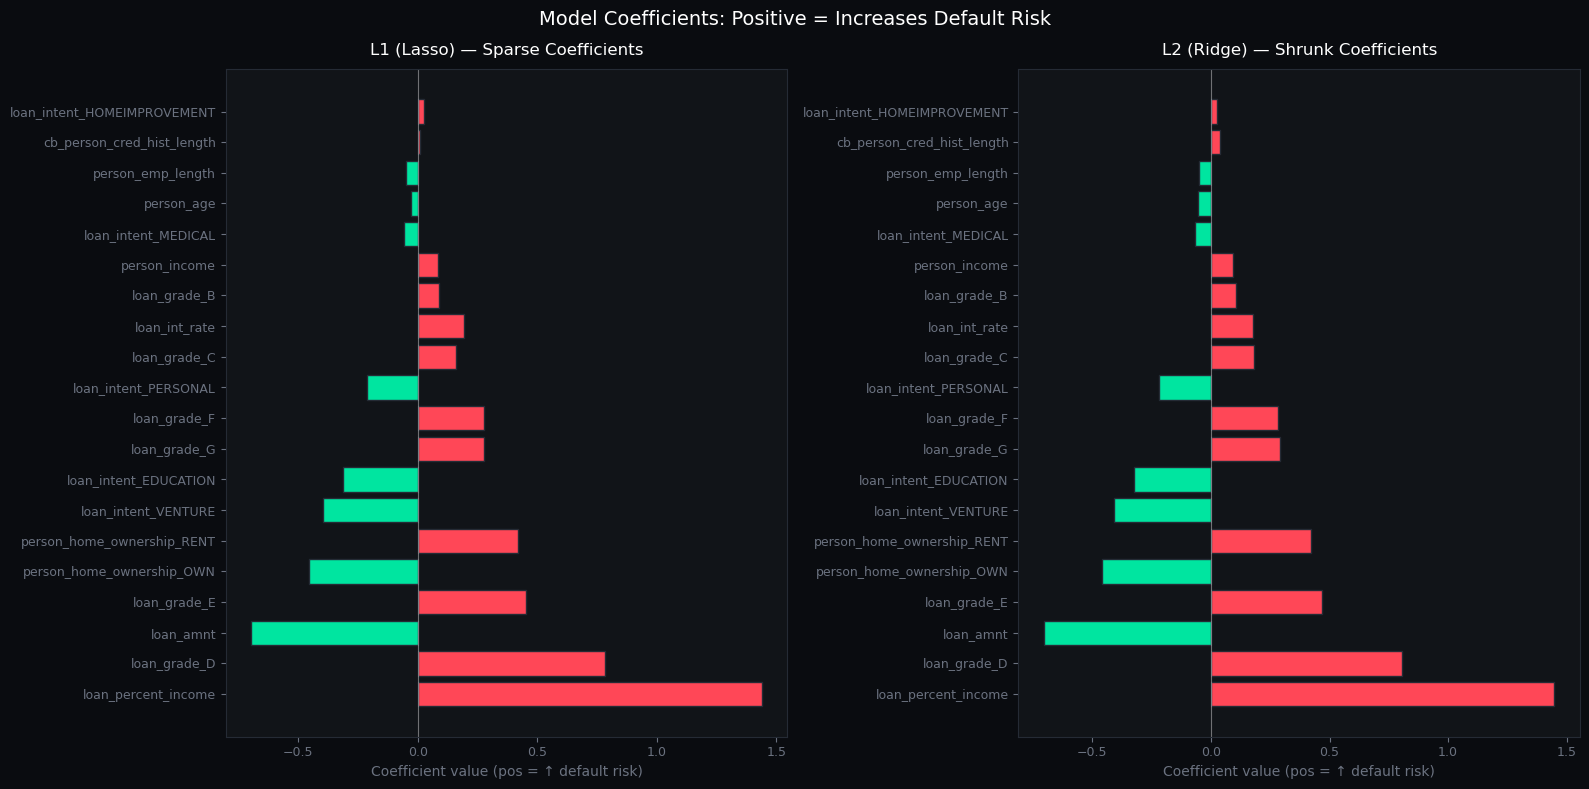


=== L1 Sparsity ===
1/22 coefficients set to exactly 0 by Lasso → automatic feature selection


In [ ]:
feature_names = X.columns.tolist()

coef_df = pd.DataFrame({
    'Feature':    feature_names,
    'L1_coef':    model_l1.coef_[0],
    'L2_coef':    model_l2.coef_[0],
}).sort_values('L2_coef', key=abs, ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.patch.set_facecolor('#0a0c10')

for ax, col, color, title in [
    (axes[0], 'L1_coef', ACCENT,  'L1 (Lasso) — Sparse Coefficients'),
    (axes[1], 'L2_coef', ACCENT2, 'L2 (Ridge) — Shrunk Coefficients'),
]:
    ax.set_facecolor('#111418')
    ax.spines[:].set_color('#252b35')
    ax.tick_params(colors='#6b7280', labelsize=9)
    top = coef_df.head(20)
    colors_bar = [DANGER if v > 0 else ACCENT for v in top[col]]
    ax.barh(top['Feature'], top[col], color=colors_bar, edgecolor='#252b35')
    ax.axvline(0, color='white', lw=0.8, alpha=0.4)
    ax.set_title(title, color='white', pad=10)
    ax.set_xlabel('Coefficient value (pos = ↑ default risk)', color='#6b7280')

fig.suptitle('Model Coefficients: Positive = Increases Default Risk', color='white', fontsize=14)
plt.tight_layout()
plt.show()

print('\n=== L1 Sparsity ===')
n_zero = (model_l1.coef_[0] == 0).sum()
print(f'{n_zero}/{len(feature_names)} coefficients set to exactly 0 by Lasso → automatic feature selection')

---
## 💡 Section 8 — Threshold Optimization & Business Interpretation

Banks have **asymmetric costs**:  
- **False Negative** (lending to a defaulter) → high financial loss  
- **False Positive** (rejecting a good client) → lost revenue  

We can tune the decision threshold $\tau$ to reflect this trade-off.

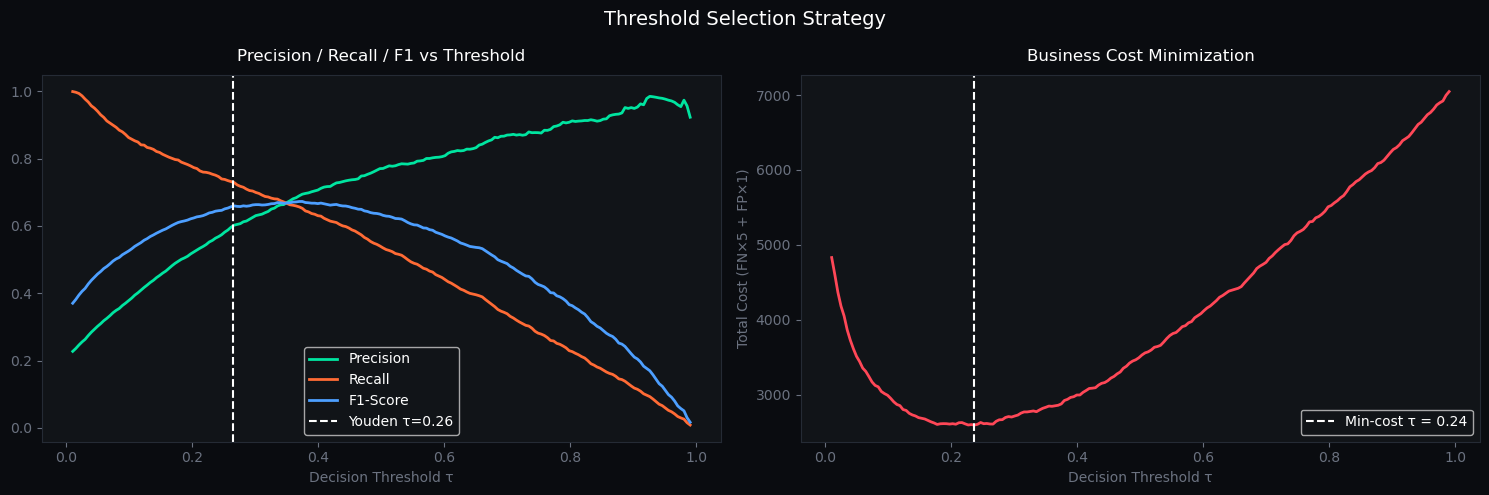

📌 Youden optimal threshold   : 0.2640
📌 Min business-cost threshold: 0.2365


In [ ]:
thresholds_range = np.linspace(0.01, 0.99, 200)
metrics = []

for t in thresholds_range:
    pred = (best_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    # Custom loss: FN costs 5x more than FP (bank scenario)
    cost = fn * 5 + fp * 1
    metrics.append({'threshold': t, 'precision': precision, 'recall': recall,
                    'f1': f1, 'cost': cost, 'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn})

met_df = pd.DataFrame(metrics)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.patch.set_facecolor('#0a0c10')

for ax in axes:
    ax.set_facecolor('#111418')
    ax.spines[:].set_color('#252b35')
    ax.tick_params(colors='#6b7280')

# Precision / Recall / F1 vs threshold
axes[0].plot(met_df['threshold'], met_df['precision'], color=ACCENT,  lw=2, label='Precision')
axes[0].plot(met_df['threshold'], met_df['recall'],    color=ACCENT2, lw=2, label='Recall')
axes[0].plot(met_df['threshold'], met_df['f1'],        color=ACCENT3, lw=2, label='F1-Score')
axes[0].axvline(opt_thresh, color='white', ls='--', lw=1.5, label=f'Youden τ={opt_thresh:.2f}')
axes[0].set_xlabel('Decision Threshold τ', color='#6b7280')
axes[0].set_title('Precision / Recall / F1 vs Threshold', color='white', pad=10)
axes[0].legend(facecolor='#111418', labelcolor='white')

# Business cost vs threshold
best_cost_idx = met_df['cost'].idxmin()
best_cost_thresh = met_df.loc[best_cost_idx, 'threshold']
axes[1].plot(met_df['threshold'], met_df['cost'], color=DANGER, lw=2)
axes[1].axvline(best_cost_thresh, color='white', ls='--', lw=1.5,
                label=f'Min-cost τ = {best_cost_thresh:.2f}')
axes[1].set_xlabel('Decision Threshold τ', color='#6b7280')
axes[1].set_ylabel('Total Cost (FN×5 + FP×1)', color='#6b7280')
axes[1].set_title('Business Cost Minimization', color='white', pad=10)
axes[1].legend(facecolor='#111418', labelcolor='white')

fig.suptitle('Threshold Selection Strategy', color='white', fontsize=14)
plt.tight_layout()
plt.show()

print(f'📌 Youden optimal threshold   : {opt_thresh:.4f}')
print(f'📌 Min business-cost threshold: {best_cost_thresh:.4f}')

---
## 🏁 Section 9 — Final Summary & Scorecard

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef

print('='*60)
print('           CREDIT RISK MODEL — FINAL SCORECARD')
print('='*60)

for name, model in [('L1 Logistic (Lasso)', model_l1), ('L2 Logistic (Ridge)', model_l2)]:
    proba = model.predict_proba(X_test_sc)[:, 1]
    pred  = (proba >= opt_thresh).astype(int)
    print(f'\n── {name} (τ = {opt_thresh:.2f}) ──')
    print(f'  AUC-ROC           : {roc_auc_score(y_test, proba):.4f}')
    print(f'  Accuracy          : {accuracy_score(y_test, pred):.4f}')
    print(f'  Balanced Accuracy : {balanced_accuracy_score(y_test, pred):.4f}')
    print(f'  MCC               : {matthews_corrcoef(y_test, pred):.4f}')
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    print(f'  TP={tp}  FP={fp}  TN={tn}  FN={fn}')
    n_zero = (model.coef_[0] == 0).sum()
    print(f'  Non-zero features : {len(feature_names) - n_zero}/{len(feature_names)}')

print('\n' + '='*60)
print('\n📚 Mathematical concepts applied:')
print('   Logistic regression — sigmoid P(default|X)')
print('   MLE — binary cross-entropy loss')
print('   L1 regularization — feature sparsity')
print('   L2 regularization — weight shrinkage + Σ stability')
print('   ROC / AUC — model discrimination power')
print('   Eigenvalue analysis — covariance matrix condition number')
print('   Threshold optimization — Youden J + business cost')
print('='*60)

           CREDIT RISK MODEL — FINAL SCORECARD

── L1 Logistic (Lasso) (τ = 0.26) ──
  AUC-ROC           : 0.8625
  Accuracy          : 0.8353
  Balanced Accuracy : 0.7980
  MCC               : 0.5572
  TP=1040  FP=692  TN=4402  FN=381
  Non-zero features : 21/22

── L2 Logistic (Ridge) (τ = 0.26) ──
  AUC-ROC           : 0.8624
  Accuracy          : 0.8345
  Balanced Accuracy : 0.7970
  MCC               : 0.5552
  TP=1038  FP=695  TN=4399  FN=383
  Non-zero features : 22/22


📚 Mathematical concepts applied:
   Logistic regression — sigmoid P(default|X)
   MLE — binary cross-entropy loss
   L1 regularization — feature sparsity
   L2 regularization — weight shrinkage + Σ stability
   ROC / AUC — model discrimination power
   Eigenvalue analysis — covariance matrix condition number
   Threshold optimization — Youden J + business cost


---
## 📖 Key Mathematical Takeaways

| Concept | Formula | Role in Credit Risk |
|---|---|---|
| **Sigmoid** | $\sigma(z)=\frac{1}{1+e^{-z}}$ | Maps score → default probability |
| **Log-Loss (MLE)** | $-\sum y_i\log\hat{p}_i+(1-y_i)\log(1-\hat{p}_i)$ | Training objective |
| **L1 Penalty** | $+\lambda\|w\|_1$ | Selects relevant risk factors |
| **L2 Penalty** | $+\lambda\|w\|_2^2$ | Prevents wild weights, stabilizes $\Sigma$ |
| **AUC-ROC** | $\int_0^1 TPR\, d(FPR)$ | Threshold-free model quality |
| **Condition number** | $\kappa=\lambda_{max}/\lambda_{min}$ | Detects multicollinearity |
| **Youden's J** | $\max_\tau(TPR-FPR)$ | Optimal classification threshold |